In [42]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import numpy as np
import pathlib
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [19]:
# mnist = tf.keras.datasets.mnist # We load our data
# (x_train, y_train),(x_test, y_test) = mnist.load_data() # We split it into test and train
# x_train, x_test = x_train / 255.0, x_test / 255.0 # Scale the data to be between 0 and 1
# plt.imshow(x_train[2])
# print(y_train[2])

In [20]:
batch_size = 32
img_height = 640
img_width = 480

In [37]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "ordered_data",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  "ordered_data",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6620 files belonging to 3 classes.
Using 5296 files for training.
Found 6620 files belonging to 3 classes.
Using 1324 files for validation.


In [38]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2']


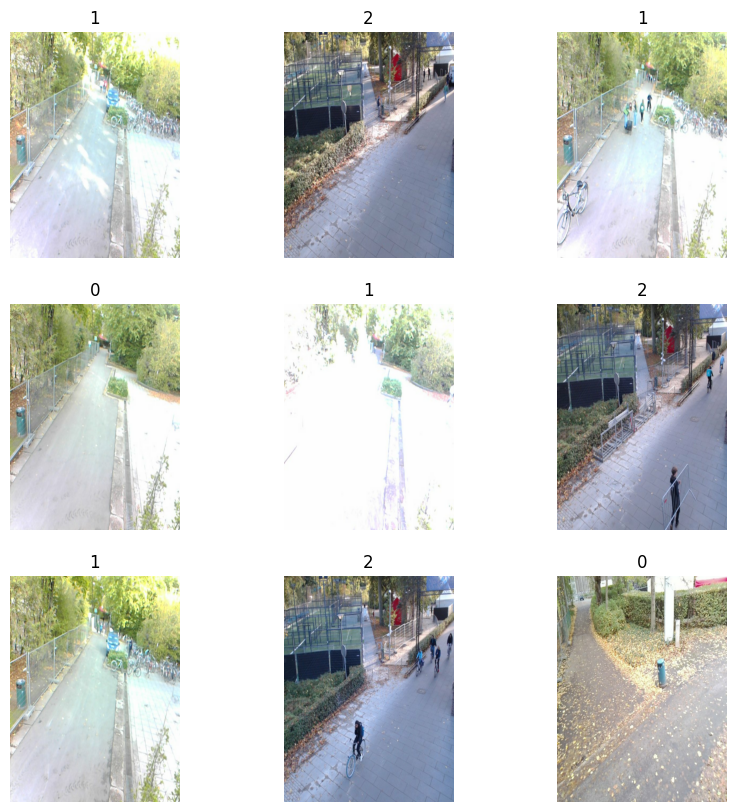

In [39]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [43]:
normalization_layer = layers.Rescaling(1./255)

In [44]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 1.0


In [45]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 640, 480, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 640, 480, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 320, 240, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 320, 240, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 160, 120, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 160, 120, 64)     

In [48]:
epochs=2
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/2
166/166 [==============================] - 1052s 6s/step - loss: 1.2705 - accuracy: 0.6101 - val_loss: 0.6279 - val_accuracy: 0.7077
Epoch 2/2
166/166 [==============================] - 743s 4s/step - loss: 0.5930 - accuracy: 0.7457 - val_loss: 0.5147 - val_accuracy: 0.7938


In [49]:
model.save("models/first_model")

INFO:tensorflow:Assets written to: models/first_model\assets


INFO:tensorflow:Assets written to: models/first_model\assets


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
# Training a regression or model from scratch (training all layers)
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

# Training the train_ds
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


TypeError: Singleton array array(<BatchDataset element_spec=(TensorSpec(shape=(None, 640, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
      dtype=object) cannot be considered a valid collection.